# ADAlyzers final project.


### Structure of the notebook.


1. Introduction.
    - What is the project about
        - Questions, etc.
    - How will we solve the problem?
2. Data description + processing.
    - General overview
        - Size of data
        - Types of data
    - Data cleaning
        - Decisions: Explain everything leading to final dataframe.
3. Featurizing. For each item: Intro + data analysis + methods.
    - Semantic similarity
    - Positional encoding
        - Images
        - Relative to paragraph
    - Curvature
4. Statistical analysis.
    - Matching
    - Tests
    - Conclusions.

---

# 1. Introduction.

Players follow different strategies.

Is the implementation of some strategy in particular correlated to success in this game? Or better, can we recommend a particular strategy to play wikispeedia?

Here, we will answer these questions by exploring a database of over 100k recorded games from real users, by using tools from natural language processing, web scrapping and network analysis, among others.

---

# 2. Data description + processing


The methodology chosen for the data processing step is to perform a **matching analysis** with the final objective to test if specific players' game strategies lead to success in the Wikispeedia game. 


A logistic regression is conducted with the goal to estimate the parameters of the logistic model with the dependent binary variable being the success, and the independent variables being sequentially extracted the following set of features (different players' choices when playing the Wikispeedia game):

1. **Positioning** of the clicked hyperlinks;
2. Clicking hyperlinks in **image captions**;
3. Clicking articles with the following **semantic similarity patterns**:
   -  increasing semantic similarity along the path between articles and the target article;
   -  increasing semantic similarity along the path between two sequentially clicked articles.
   
Several **confounders** may affect the outcome of the regression analysis i.e. of the potentially found correlation between the aforementioned features and success. <br>
To mention a few, the **“difficulty”** of the randomly assigned task (source and target articles), affects the players' successfulness together with the strategy adopted to address it. This “difficulty” could be naively measured by **shortest path distance** between the source and target article in the Wikispeedia hyperlinks graph (calculated with the Floyd-Warshall algorithm). <br>

Additionally, **characteristics** of the human paths, probably independent of the strategy, may also impact the final outcome. For this reason, we wish to compare only similar paths, and the way we will do this is by calculating "player agnostic", path specific features. We do this by considering the local features of the edges in the wikipedia graph (adjacent nodes' in- and out- degrees, and derived quantities). These features will be used to compare the similarity of different paths.


In order to remove the aforementioned confounders, the dataset is filtered and the matching is performed accordingly with the assumptions made. 


Players are matched on same **shortest path distance** of the assigned task, and maximum **propensity score** (see __Statistical analysis__), with the **treated subject** being the user performing a specific strategy (e.g. clicking more frequently than the average on hyperlinks showing up in images’ captions) and the **controlled subject** being the user NOT performing the strategy. 

The analysis challenge can be reformulated as follows: **"being assigned an equally difficult task, and having played a similar game, are players more successful if they adopt some specific strategy?"**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.parse
import seaborn as sns
import os, sys

In [4]:
data_path = "data/"
parent_folder_path = data_path + 'wikispeedia_paths-and-graph/'

paths_finished_df=(pd.read_csv(os.path.join(parent_folder_path, 'paths_finished.tsv'), 
                               sep='\t', skiprows=15, header=None)
                   .rename(columns={0:"ip",
                                    1:"timestamp",
                                    2:"duration",
                                    3:"path",
                                    4:"rating"}))

paths_unfinished_df=(pd.read_csv(os.path.join(parent_folder_path, 'paths_unfinished.tsv'), 
                               sep='\t', skiprows=16, header=None)
                     .rename(columns={0:"ip",
                                      1:"timestamp",
                                      2:"duration",
                                      3:"path",
                                      4:"target",
                                      5:"type"}))
articles_df=pd.read_csv(os.path.join(parent_folder_path, 'articles.tsv'), 
                        sep='\t', skiprows=12, header=None, names=['article'])


# Get a list of article names.

import urllib.parse
def str_url_format(word):
    """
    Article name preprocessing.
    
    Preprocessing of article names (url encoded)
    """
    return (urllib.parse.unquote(word)
            .replace("_", " ")
            .strip()
            .lower())

article_names_cleaned = (pd.read_csv(data_path + 'wikispeedia_paths-and-graph/articles.tsv', 
                                     sep='\t', 
                                     skiprows=11,
                                     header=None)[0]
                         .apply(str_url_format)
                         .values
                         .tolist()
                        )

article_names_cleaned[:3]

['áedán mac gabráin', 'åland', 'édouard manet']

### Load `successful` and `unsuccessful` paths. For each path, find the shortest length path from the `source` to the `target`

In [5]:
# first read the shortest path matrix
shortest_path_matrix = []

with open(data_path + 'wikispeedia_paths-and-graph/shortest-path-distance-matrix.txt', 'r') as f:
    # the first 17 lines (indexed from 0) is the file description 
    for line in f.readlines()[17:]:
        shortest_path_matrix.append(line)
        
# the matrix now stores all shortest paths from all source articles
len(shortest_path_matrix)

4604

In [6]:
# for each human path, perform the following steps:
#      1. extract the source and target article
#      2. find the *index* in the article names list that corresponds to the source and target article
#      3. the corresponding *index* row in the shortest path matrix corresponds to the source article. 
#         from this list of numbers, use the target article *index* to find the *shortest path length*

def augment_with_shortest_path(df: pd.DataFrame, successful: bool) -> pd.DataFrame:
    """
    this function takes a Series and returns a DataFrame with the following columns:
       1. path
       2. source article
       3. target article
       4. shortest path length
       
    input:
       df: the Pandas DataFrame containing all the human navigation paths
       successful: a boolean indicating whether the paths were successful or not
    """
    # remove all paths with back-tracks
    df = df[~df['path'].str.contains('<')]        
    paths, human_path_lengths, source_articles, target_articles, shortest_paths = [], [], [], [], []
    
    # all information required for successful paths is in the path itself
    if successful:
        for human_path in df['path']:

            split_path = str_url_format(human_path).split(";")
            
            paths.append(";".join(split_path))
            # subtract 1 because we do not count the source article
            human_path_lengths.append(len(split_path)-1)

            source = split_path[0]
            target = split_path[-1]
            source_articles.append(source)
            target_articles.append(target)
    
    # unsuccessful paths require extraction of the target article from a separate column
    else:
        for human_path, target in zip(df['path'], df['target']):
            
            split_path = str_url_format(human_path).split(";")
            paths.append(";".join(split_path))
            # subtract 1 because we do not count the source article
            human_path_lengths.append(len(split_path)-1)

            source = split_path[0]
            target = str_url_format(target)
            source_articles.append(source)
            target_articles.append(target)
        
    for source, target in zip(source_articles, target_articles):
        source_index = article_names_cleaned.index(source)
        # there are target articles that were not provided in the plain text files
        try:
            target_index = article_names_cleaned.index(target)
        except Exception:
            shortest_paths.append("N/A")
            continue
            
        # query the shortest path matrix to get the correct vector (corresponding to the source article)
        shortest_path_vector = shortest_path_matrix[source_index]
        # now find the target article indexed integer in the vector
        shortest = shortest_path_vector[target_index]
        # it's not always possible to get to the target article. Impossible navigation is denoted by "_"
        if shortest == "_":
            shortest_paths.append("Impossible")
        else:
            shortest_paths.append(int(shortest))
        
        
    # create the augmented DataFrame
    out = pd.DataFrame({
                      'path': paths,
                      'source_article': source_articles,
                      'target_article': target_articles,
                      'human_path_length': human_path_lengths,
                      'shortest_path_length': shortest_paths
                      })
    
    return out

In [7]:
### Load successful paths
successful_df = augment_with_shortest_path(df=paths_finished_df, successful=True)
# to investigate human behaviour, we remove all "Impossible paths" and also shortest_path_length = 0
successful_df = successful_df[(successful_df['shortest_path_length'].apply(lambda x: x != 'Impossible' and x != 0))]
# next, we will keep only shortest_path_lengths >= 3
# successful_df = successful_df[(successful_df['shortest_path_length'].apply(lambda x: x >= 3))]
successful_df = successful_df[(successful_df['human_path_length'].apply(lambda x: x >= 3))]


### Load unsuccessful paths
unsuccessful_df = augment_with_shortest_path(df=paths_unfinished_df, successful=False)

# some target articles for unsuccessful paths were not provided in the plain_text folder, denoted in
# the DataFrame as "N/A". Remove these
unsuccessful_df = (unsuccessful_df[(unsuccessful_df['shortest_path_length']
                                    .apply(lambda x: x != 'N/A' and x != 'Impossible'))])

# some unsuccesful paths only contain 1 article because the user didn't click anything
# these are less meaningful paths to analyze as we are interested in users who tried but failed
# we will keep paths where the human clicked at least 3 articles

#unsuccessful_df = unsuccessful_df[(unsuccessful_df['shortest_path_length'].apply(lambda x: x >= 3))]
unsuccessful_df = unsuccessful_df[(unsuccessful_df['human_path_length'].apply(lambda x: x >= 3))]

### General overview of the paths data

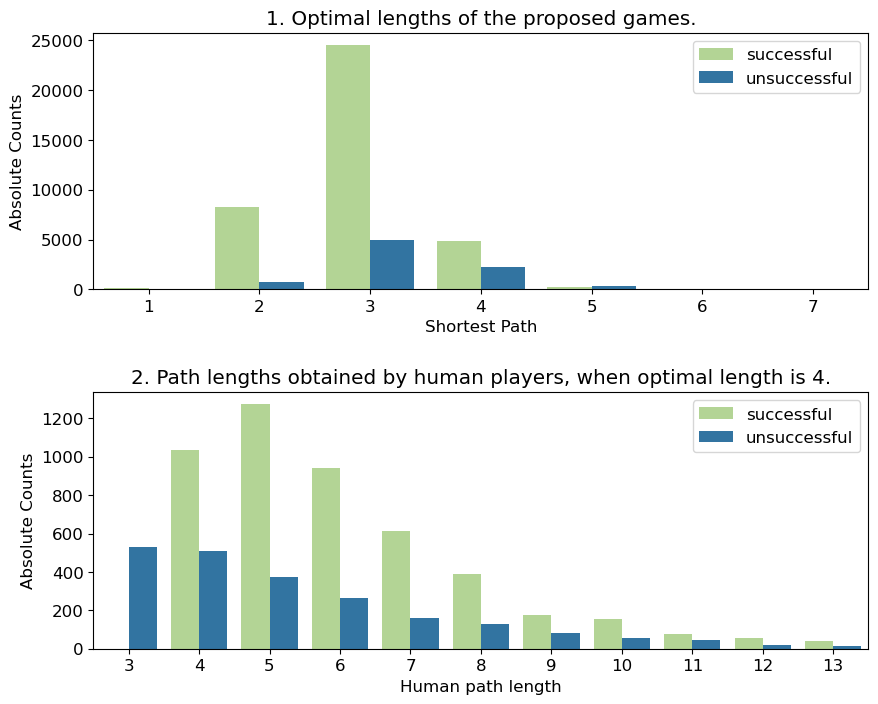

In [10]:
# take a look at the shortest_path distributions
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(2,1, 
                       figsize=(10,8), 
                       gridspec_kw={"hspace":0.4})
plt.rcParams["font.size"] = 12


successful_counts = (successful_df['shortest_path_length']
                     .value_counts()
                     .reset_index())
successful_counts["success"] = "successful"

unsuccessful_counts = (unsuccessful_df['shortest_path_length']
                       .value_counts()
                       .reset_index())
unsuccessful_counts["success"] = "unsuccessful"

all_counts = pd.concat([successful_counts, 
                        unsuccessful_counts], 
                       axis=0)

sns.barplot(data=all_counts, 
            x="index", 
            y="shortest_path_length", 
            hue="success",
            ax=ax[0], 
            palette=["#b2df8a", "#1f78b4"])

ax[0].set_ylabel('Absolute Counts'); 
ax[0].set_xlabel('Shortest Path');
ax[0].set_title("1. Optimal lengths of the proposed games.")
#Count of human paths, stratified by shortest possible path")

ax[0].legend(loc=1)
ax[0].set_ylabel('Absolute Counts') 
ax[0].set_xlabel('Shortest Path')



# Next plot: frequency by human length
n = 4
successful_human_path_lengths_n = (successful_df
                                   [successful_df['shortest_path_length'] == n]
                                   ['human_path_length']
                                   .value_counts()
                                   .reset_index())

successful_human_path_lengths_n["success"] = "successful"

unsuccessful_human_path_lengths_n = (unsuccessful_df
                                     [unsuccessful_df['shortest_path_length'] == n]
                                     ['human_path_length']
                                     .value_counts()
                                     .reset_index())

unsuccessful_human_path_lengths_n["success"] = "unsuccessful"

all_path_ln = pd.concat([successful_human_path_lengths_n,
                         unsuccessful_human_path_lengths_n])

sns.barplot(data=all_path_ln, 
            x="index", 
            y="human_path_length", 
            hue="success", 
            ax=ax[1],
            palette=["#b2df8a", "#1f78b4"])

ax[1].set_xlim(-0.5,10.5)

ax[1].set_ylabel('Absolute Counts')
ax[1].set_xlabel('Human path length')
ax[1].set_title(f"2. Path lengths obtained by human players, when optimal length is {n}.")
# Count of human path lengths, with shortest possible path = n");

ax[1].legend(loc=1);

`shortest_path_distance` is taken as a proxy to game difficuly. First plot shows that, as difficulty increases, the class unbalance decreases. An OL of 5 is already too hard, and most paths are unsuccessful, however the data here is too scarce. As there is still enough data for `shortest_path_distance`==4, and the classes seem better balanced, we will center our attention on this subset of the data for the rest of the analysis.


Second plot above shows the length of the actual paths taken by humans, on the subset with `shortest_path_distance`==4. Successful paths have mostly a length of 5, but the distribution spreads to higher values. Distribution of unsuccessful paths is severely skewed to the left and peaks in 3, meaning that in such paths, players give up before even having a chance to win. This shows that the distribution of paths is very different for both populations, which leads us to conclude that we have to perform a matching study to draw any conclussions at all.
 

### Next steps will augment the dataset with path specific features.

In [11]:
successful_df['is_successful'] = 1
unsuccessful_df['is_successful'] = 0

# merge the successful and unsuccessful DataFrames
final_df = pd.concat([successful_df, unsuccessful_df])
final_df.reset_index(drop=True, inplace=True)


# save the final DataFrame used for the analysis
final_df.to_csv('processed/final_df.csv', index=False)

final_df.head(3)
# next, we will calculate "treatments" involving semantic distance metrics for the DataFrame

,path,source_article,target_article,human_path_length,shortest_path_length,is_successful
0,14th century;15th century;16th century;pacific...,14th century,african slave trade,8,3,1
1,14th century;europe;africa;atlantic slave trad...,14th century,african slave trade,4,3,1
2,14th century;niger;nigeria;british empire;slav...,14th century,african slave trade,7,3,1


---

# 3. Featurization

## Featurization a. Link clickability: positional encoding of hyperlinks.

#### Introduction.
Our first question is: is the relative position of a hyperlink within an article an indicator of success in a game? e.g. if the player clicks mostly links in images, or links that appear in the bottom of the page, are they more prone to win?

This comes from the heuristic that link positioning is an indirect way of classifying articles: in the top of the page we find more general, as well as more contextual concepts, while as we further read an article, relations between concepts become more specific.

---

To get the distribution of players' clickability preference with regard to the positioning of the hyperlinks throughout the article text, the following protocol is implemented:
1. parse Wikispeedia articles html files in order to get the **most frequent positioning*** per each hyperlink;
2. parse the **human paths** (i.e. sequence of clicked articles) and attribute to each link its most frequent positioning (on the basis of the categorization above);
3. group by **positioning**** and count the **number of occurences*****;
4. normalize;
5. plot the distributions of successful and unsuccessful players. 

\*each article is divided into paragraphs: on the basis of the relative (to the article length) paragraph the hyperlink shows up, it is assigned a categorical label, which indicates its positioning; then, to each hyperlink name, its most frequent label, throughout the Wikispeedia library, it is assigned. <br>
\*\*`positioning` is a categorical variable with possible labels `top`, `top-center`, `center`, `center-bottom`, `bottom`. <br>
\*\*\* do this separately for successful and unsuccessful players.


#### 1. Parse Wikispeedia articles

The full implementation of the code can be found in P2-Notebook.ipynb, here only the qualitative results are reported.  

`most_freq_positioning_df` stores the most frequent positionings for each hyperlink:

In [19]:
data_processed_folder = "processed/POS_IMG/"
most_freq_positioning_df=pd.read_csv(data_processed_folder+'most_freq_positioning_df.csv', index_col=0)
most_freq_positioning_df.tail()

,link,most_freq_positioning
10528,‘6 villages for 2006’,center-top
10529,“6 villages for 2006”,center
10530,€,center-bottom
10531,€25 million,top
10532,↑,center


#### 2. Parse human paths 

`links_freq_pos_f` and `links_freq_pos_u` store the frequency of players' clicks and the most frequent positioning per hyperlink (respectively for finished paths and unfinished paths, i.e. successful and not succesful players): 

In [20]:
links_freq_pos_f=pd.read_csv(data_processed_folder+'links_freq_pos_f.csv', index_col=0)
links_freq_pos_f[:10]

,link,#_clicks,most_freq_positioning
0,áedán mac gabráin,0.0,top
1,åland,1.0,bottom
2,édouard manet,1.0,center-bottom
3,éire,1.0,top
4,óengus i of the picts,0.0,center
5,€2 commemorative coins,1.0,center
6,10th century,66.0,top
7,11th century,82.0,top
8,12th century,95.0,top
9,13th century,82.0,top


In [21]:
print('In {0} out of {1} cases clicked links by players don\'t have a most frequent positioning as they do not show up \
in the dataframe containing hyperlinks in HTML pages. They are replaced with random values.'\
      .format((links_freq_pos_f['most_freq_positioning'].isna()).sum(), len(links_freq_pos_f)))
links_freq_pos_f['most_freq_positioning'].\
fillna(np.random.choice(['top', 'center-top','center','center-bottom', 'bottom']),inplace=True)

In 0 out of 11520 cases clicked links by players don't have a most frequent positioning as they do not show up in the dataframe containing hyperlinks in HTML pages. They are replaced with random values.


#### 3. 4. 5. Count, normalize and plot

The **number of clicks** are grouped by the categorical variable _positioning_ and summed up. The number of clicks per _positioning_ are normalized by the total number of clicks; the **number of occurrencies** of hyperlinks in Wikispeedia articles are grouped by, summed up and normalized by the total number of clickable hyperlinks in the library. <br> 
The dataframes `succesful_pos_df` and `unsuccesful_pos_df` store hyperlinks' number of clicks `#_clicks`, number of occurrencies `nr`, both the values normalized `#_clicks_norm`, `nr_norm` and the latters' ratio **`#_clicks / #_hyperlinks`**, the result of our interest. 

In [22]:
succesful_pos_df=pd.read_csv(data_processed_folder+'vis_f.csv', index_col=0)
unsuccesful_pos_df=pd.read_csv(data_processed_folder+'vis_u.csv', index_col=0)
succesful_pos_df

,#_clicks,#_clicks_norm,nr,nr_norm,#_clicks / #_hyperlinks,is_successful
bottom,24085.0,0.099419,24193,0.184871,0.537775,1
center,20014.0,0.082615,20228,0.154573,0.534472,1
center-bottom,15623.0,0.064489,22588,0.172607,0.373620,1
center-top,18631.0,0.076906,23031,0.175992,0.436986,1
top,163904.0,0.676571,40824,0.311957,2.168792,1


In [23]:
unsuccesful_pos_df

,#_clicks,#_clicks_norm,nr,nr_norm,#_clicks / #_hyperlinks,is_successful
bottom,6529.0,0.095021,24193,0.184871,0.513985,0
center,3768.0,0.054838,20228,0.154573,0.354774,0
center-bottom,6516.0,0.094832,22588,0.172607,0.549411,0
center-top,4941.0,0.071910,23031,0.175992,0.408598,0
top,46957.0,0.683399,40824,0.311957,2.190679,0


The plot **`Distribution of clicks and hyperlinks positioning`** juxtaposes the distribution of players clicks per _positioning_ and the same for hyperlinks occurrencies in the Wikispeedia articles. `Distribution of clickability preference` visualizes the players preferences with regard to the hyperlinks positioning throughout the article text:


More precisely:

- a value of 1 ( **#_clicks/#_hyperlinks == 1** ) corresponds to a **hyperlinks clickability on average equally proportional to the normalized frequency of the specific categorical positioning** (i.e. the number of clicks proportional to the number of times a hyperlink shows up in a section of the article);
- a value of greater than 1, points a more than proportional clickability;
- a value of smaller than 1, points a less than proportional clickability.

**Successful** and **unsuccessful players preferences** are juxtaposed in the graph **`Distribution of clickability preference`**:

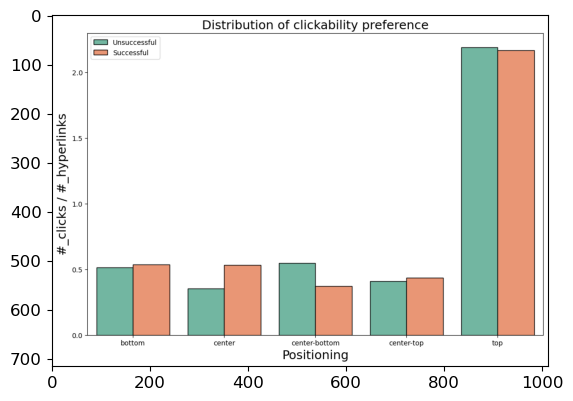

In [27]:
#determine which one is better
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(data_processed_folder+'Distribution_clickability_preference_pos.png')
imgplot = plt.imshow(img)
plt.show()

There is an evident players' clickability preference for hyperlinks showing up at the **top of articles**, followed by a preference for **bottom** and center-bottom positionings. <br>
The **largest gap** between successful and unsuccessful is for the center-bottom-positioned hyperlinks: successful players click on average less than unsuccessful ones. They share this trend with top-positioned links, while the **trend** is **reversed** for bottom-, center- and center-top-positioned links. <br>
Center-positioned links are clicked the least, both by successful and unsuccessful players.

For further understanding of players' response to the game and the structure of the game itself, it's interesting to **test** whether clicking on a specific categorical positioning of the hyperlinks throughout the text **leads players to succeed** or not. The two behaviours that will be further investigated are clicking on top-positioned and bottom-positioned hyperlinks. The two are the trendiest among players and present reversed patterns w.r.t. successfulness: these reasons motivate the choice.

### Hyperlinks clickability: image captions

To get the distribution of players' clickability preference with regard to the positioning of the hyperlinks throughout the article text, the following protocol is implemented:
1. parse Wikispeedia articles html files in order to get the **list of hyperlinks** that show up **in image captions**;
2. parse the **human paths** (i.e. sequence of clicked articles) and count the clicked hyperlinks that show up in image captions (on the basis of the categorization above);
3. group by a hyperlink being in an **image captions*** or not and count the **number of occurences**;
4. normalize;
5. plot the distributions. 

\*`in_image` is a binary variable indicating whether the hyperlink shows up in image captions or not. 

#### 1. Parse Wikispeedia articles

The full implementation of the code can be found in P2-Notebook.ipynb, here only the qualitative results are reported.

`links_in_images_list` stores the list of links present in image captions:

In [28]:
link_in_img_list=pd.read_csv(data_processed_folder+'links_in_images_unique.csv', index_col=0).values[:,0].tolist()
link_in_img_list[:5]

['bangladesh', 'portsmouth', 'england', 'india', 'pompeii']

`link_in_image_freq_df` stores the number of occurrencies in image captions, throughout the Wikispeedia library,  per hyperlink.

In [29]:
link_in_image_freq_df=pd.read_csv(data_processed_folder+'link_in_img_freq_df.csv', index_col=0)
link_in_image_freq_df[:5]

,link,#_link_in_img
0,scientific classification,508
1,NaN,424
2,animalia,398
3,time zone,340
4,chordata,330


#### 2. 3. Parse human paths and count

`successful_img_df` and `unsuccessful_img_df` store the number of players' clicks `#_clicks`, a flag `in_image` specifying if the hyperlink shows up in an image caption, the occurrencies in image captions and in the articles `#_link_in_img`, `#_link_in_article` per hyperlink, computed for finished paths and unfinished paths (i.e. successful and unsuccessful players).

In [30]:
successful_img_df=pd.read_csv(data_processed_folder+'new_df_img_f.csv', index_col=0)
unsuccessful_img_df=pd.read_csv(data_processed_folder+'new_df_img_u.csv', index_col=0)
successful_img_df[:10]

,link,#_clicks,in_image,#_link_in_img,#_link_in_article
0,áedán mac gabráin,0,0,0.0,2.0
1,åland,1,1,1.0,4.0
2,édouard manet,1,1,1.0,10.0
3,éire,1,0,0.0,3.0
4,óengus i of the picts,0,0,0.0,0.0
5,€2 commemorative coins,1,0,0.0,0.0
6,10th century,66,0,0.0,37.0
7,11th century,82,1,1.0,29.0
8,12th century,95,0,0.0,59.0
9,13th century,82,0,0.0,59.0


####  4. 5. Normalize and plot

`successful_norm_df` and `unsuccessful_norm_df` store the normalized click frequency for hyperlinks in image captions and not. The normalization took into account that hyperlinks showing up in image captions also occur in article texts, therefore the frequency of clicks `#_clicks` was scaled to the relative occurrency in image caption to article text (`#_link_in_img`/`#_link_in_article`), and both were normalized to the total number of occurrencies in image captions or in article texts. The final dataframe with the aforementioned features is `final_img_df`. 

In [31]:
successful_norm_df=pd.read_csv(data_processed_folder+'links_freq_img_f_norm.csv', index_col=0)
successful_norm_df.head(10)

,link,#_clicks_norm,in_image
0,áedán mac gabráin,0.00,0
1,åland,1.00,1
2,édouard manet,0.60,1
3,éire,2.00,0
4,óengus i of the picts,0.00,0
5,€2 commemorative coins,2.00,0
6,10th century,132.00,0
7,11th century,5.66,1
8,12th century,190.00,0
9,13th century,5.56,1


In [32]:
final_img_df=pd.read_csv(data_processed_folder+'vis_img.csv', index_col=0)
final_img_df

,#_clicks_norm,#_clicks / #_links_img,is_successful
in_image,,,
0,193052.00,1.673866,1
1,132289.39,8.517764,1
0,57666.00,0.499996,0
1,45057.67,2.901144,0


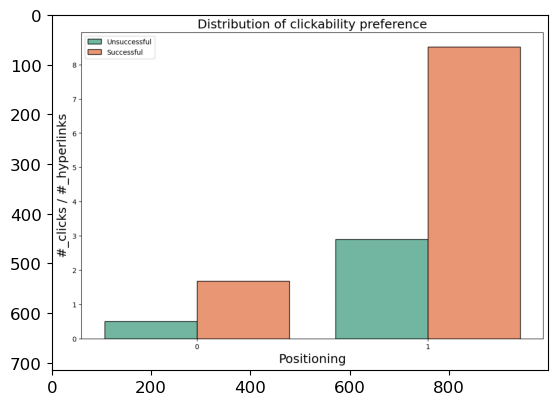

In [34]:
img = mpimg.imread(data_processed_folder+'Distribution_clickability_preference_img.png')
imgplot = plt.imshow(img)
plt.show()

It is evident that **clicking** hyperlinks showing up in **image captions** is a **trendy** behavior for Wikispeedia players, especially among the **successful**. The rate of successful players clicking on image captions is roughly 4 times the unsuccessful players one. It is of interest for our study to test if this peculiar strategy can lead Wikispeedia players to success. To this end a matched analysis will be conducted.

## Featurization b. Semantic similarity Between Wikipedia Articles: 'Bag-of-Words' Cosine Similarity Based on Word Frequencies

We are interested in measuring ***similarity*** between `Wikipedia` articles to investigate players' strategies in `Wikispeedia`. The proposed similarity is `Cosine Similarity` measured on word frequencies given a pair of articles. **Therefore, the assumption we make is that articles with similar occurrences of words are similar.** 

In order to mitigate similarity due to common English words such as "the", we apply a filter as follows:

1. Remove all `Stop` words as defined in `Scikit-learn`
* https://scikit-learn.org/stable/modules/feature_extraction.html#nqy18

2. Remove all white spaces and `\n` characters


3. Apply a scaled version of word frequency count as implemented in `TfidfTransformer` in `Scikit-learn`: 
* https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer

The cell blocks below show our data processing pipeline.

In [50]:
import os

data_path = 'data/'
base_path = data_path + 'plaintext_articles'
articles = os.listdir(base_path)
# sort the article names in alphabetical order. This is not strictly required
articles = sorted(articles)

def remove_duplicates_and_fix_names(articles: list):
    """this function parses all the articles provided in the plaintext folder and stores the
       names of all the articles after "cleaning" them (some articles containing accents have encoded names).
       The raw text from the files are also stored in a list after removing white spaces and empty lines."""
    
    def parse_text(article: str) -> str:
        """this helper function reads a raw text file and removes white spaces and empty lines."""
        with open(os.path.join(base_path, article)) as f:
            # remove white spaces
            raw_text = [line.rstrip() for line in f.readlines()]
            # remove empty lines
            raw_text = [line.strip() for line in raw_text if line != '']
            return str(raw_text)
    
    # some article names have errors - fix these
    article_names_cleaned, texts = [], []
    
    for art_name in articles:
        texts.append(parse_text(art_name))
        article_names_cleaned.append(str_url_format(art_name))
                    
    
    # remove ".txt" from the article names
    article_names_cleaned = [article.replace('.txt', '') for article in article_names_cleaned]
    # remove list bracket from string casting of raw text
    texts = [text.replace('[', '') for text in texts]
    
    return article_names_cleaned, texts

article_names_cleaned, texts = remove_duplicates_and_fix_names(articles)

In [53]:
# count word frequency using sklearn out-of-the-box functions
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd
import numpy as np

# remove common stop words
tfid_vectorizer = TfidfVectorizer(stop_words='english')
# apply CountVectorizer and TfidfTransform sequentially
matrix = tfid_vectorizer.fit_transform(texts)
matrix = matrix.todense()

# by default, "TfidfVectorizer" uses l2 norm and thus, to obtain the Cosine Similarity,
# we simply perform a dot product of the matrix
cosine_sim = pd.DataFrame(np.dot(np.array(matrix), np.array(matrix).T), columns=article_names_cleaned)
# assign the index names also as the article names. This is used for easy querying pairs of articles
cosine_sim.index = article_names_cleaned        
cosine_sim

,áedán mac gabráin,åland,édouard manet,éire,óengus i of the picts,€2 commemorative coins,10th century,11th century,12th century,13th century,...,ziad jarrah,zimbabwe,zinc,zinc chloride,zion national park,zionism,zirconium,zoroaster,zuid-gelders,zulu
áedán mac gabráin,1.000000,0.003680,0.006182,0.047190,0.183846,0.004210,0.008076,0.012168,0.013427,0.011928,...,0.004239,0.006244,0.001843,0.002172,0.003523,0.006111,0.001494,0.008908,0.001593,0.012721
åland,0.003680,1.000000,0.008423,0.017851,0.004137,0.043866,0.007999,0.004936,0.004993,0.013233,...,0.004768,0.023149,0.002752,0.002160,0.007089,0.016041,0.003315,0.005287,0.008188,0.012883
édouard manet,0.006182,0.008423,1.000000,0.009609,0.006520,0.014643,0.011617,0.008879,0.011491,0.011438,...,0.010377,0.011835,0.004556,0.002780,0.011044,0.014414,0.004934,0.009887,0.005441,0.012838
éire,0.047190,0.017851,0.009609,1.000000,0.049035,0.033312,0.012264,0.008489,0.033374,0.015251,...,0.009314,0.038388,0.006863,0.005671,0.005486,0.031955,0.005751,0.012004,0.004430,0.019581
óengus i of the picts,0.183846,0.004137,0.006520,0.049035,1.000000,0.006741,0.012741,0.013508,0.020239,0.012106,...,0.004763,0.008280,0.002700,0.002718,0.005656,0.008067,0.001780,0.009081,0.001923,0.015018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zionism,0.006111,0.016041,0.014414,0.031955,0.008067,0.017812,0.019210,0.021355,0.024060,0.023037,...,0.012631,0.038386,0.007253,0.003734,0.028964,1.000000,0.006372,0.016985,0.004575,0.026654
zirconium,0.001494,0.003315,0.004934,0.005751,0.001780,0.006597,0.007255,0.005258,0.004183,0.005319,...,0.003589,0.010286,0.065117,0.038394,0.005937,0.006372,1.000000,0.005025,0.003256,0.004729
zoroaster,0.008908,0.005287,0.009887,0.012004,0.009081,0.010104,0.021481,0.019697,0.017953,0.024732,...,0.008748,0.014037,0.005008,0.003395,0.009401,0.016985,0.005025,1.000000,0.003077,0.011154
zuid-gelders,0.001593,0.008188,0.005441,0.004430,0.001923,0.005124,0.004908,0.004378,0.002217,0.004719,...,0.003414,0.008758,0.002613,0.002273,0.004882,0.004575,0.003256,0.003077,1.000000,0.008353


Text(0, 0.5, 'Absolute Counts')

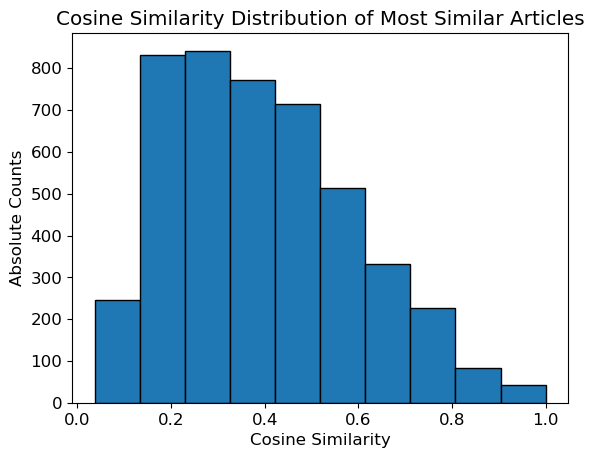

In [54]:
import matplotlib.pyplot as plt

# let's take a look at the Cosine Similarity distribution of the most similar article to a given article
most_similar = []
for idx in range(len(cosine_sim)):
    # index [-2] because index [-1] is always = 1 since it is a self similarity
    most_similar.append(sorted(cosine_sim.iloc[idx])[-2])
    
# plot the similarities
pd.Series(most_similar).plot(kind='hist', edgecolor='k')
plt.title("Cosine Similarity Distribution of Most Similar Articles")
plt.xlabel("Cosine Similarity"); plt.ylabel("Absolute Counts")

# there are no glaring red flags, e.g., most Cosine Similarities close to 0 or 1

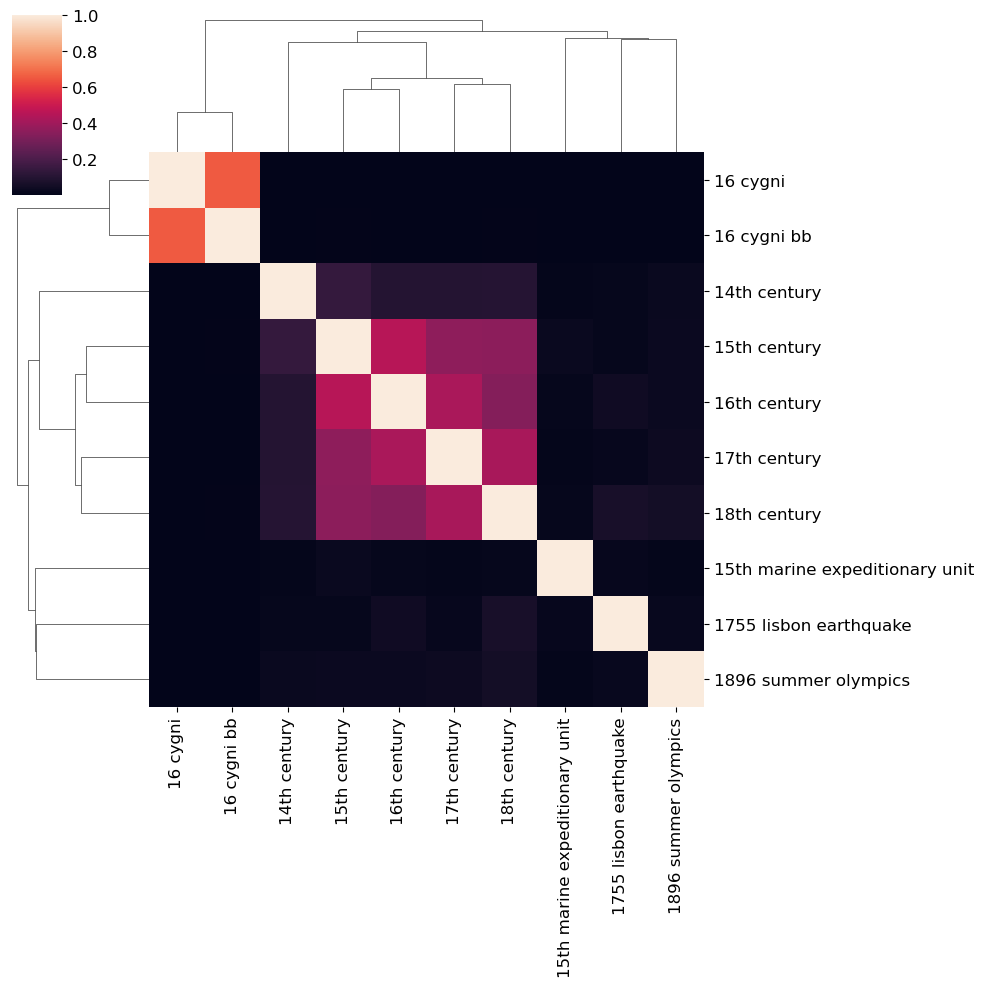

In [55]:
import seaborn as sns

# "Cygni" are star systems/extrasolar planets and thus are expected to be similar
# the time periods have some similarity
sns.clustermap(cosine_sim.iloc[10:20, 10:20])

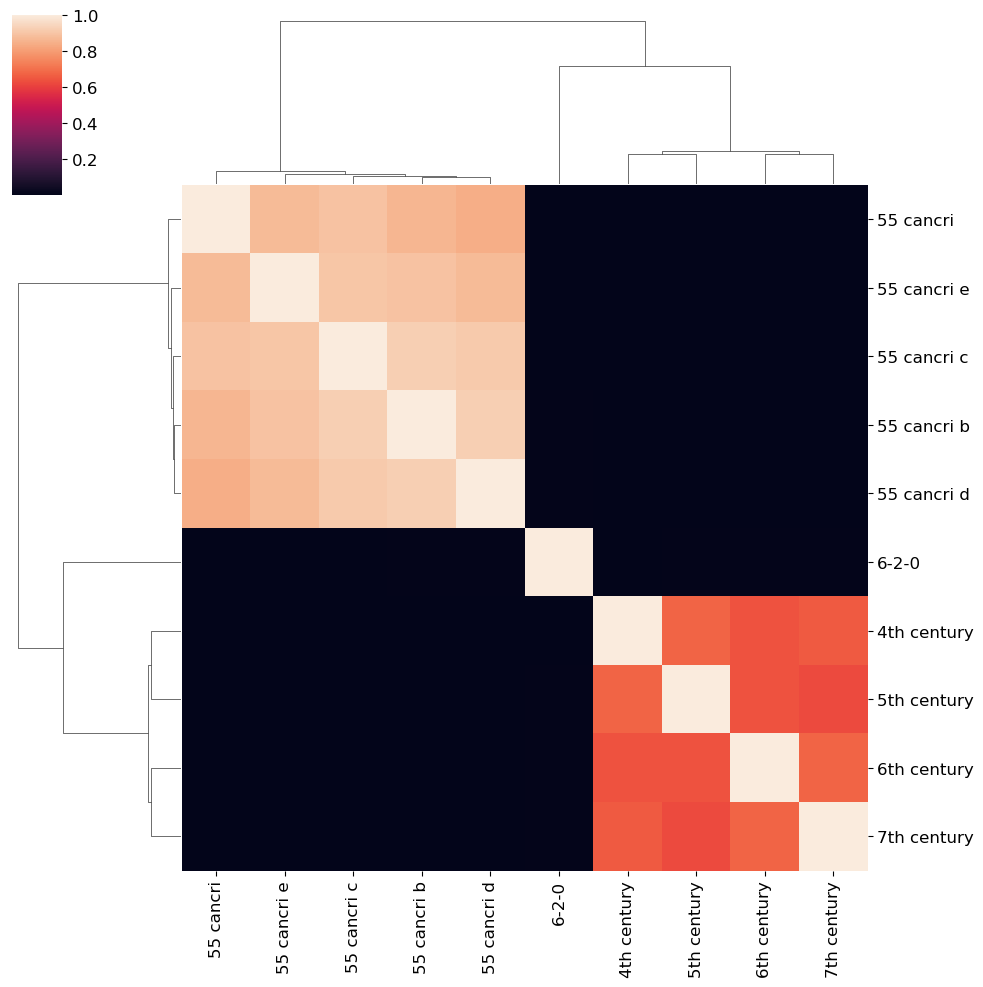

In [56]:
# "Cancri" are exoplanets and thus are expected to be similar
# we again see similarity between time periods
sns.clustermap(cosine_sim.iloc[50:60, 50:60])

In [88]:
def get_path_cosine_similarity(path: str, matrix: pd.DataFrame, method: str='sequential') -> list:
    """this function takes a navigation path string and returns an array of the Cosine Similarity.
       Two methods are supported: 'sequential' (default) which measures the sequential similarity and 
       'target' which measures the similarity between the current article at the target article.
       
       Input:
       path: navigation path string
       matrix: pre-computed Cosine Similarity matrix
       method: measurement method (defaults to 'sequential')
       
       Return:
       list: list of similarity measures
    """
    
    # there is 1 article that is duplicated in the plaintext folder. Problematically, the duplicated
    # article has different names and navigation paths can point to these different names, yet the 
    # article is the same. This one exception is handled here. In the implementation, we do not have to 
    # worry about this particular article pointing back to itself as it is not possible
    
    # navigation paths are separated by ";"
    path = path.split(';')
    
    # if the path only contains the starting article, return None
    if len(path) == 1:
        return None
    
    path_sims = []
    
    def get_correct_name(query: str, base_path: str=data_path + 'plaintext_articles') -> str:
        """this nested function is called in case a path contains error characters.
           Returns the fixed path so it can be used to query the Cosine Similarity matrix."""
        if '_' in query and '%' not in query:
            return query
        elif query in ['Podcasting', 'Color', 'Fencing', 'Anemia', 'Quito']:
            return query
        else:
            with open(os.path.join(base_path, f'{query}.txt'), 'r') as f:
                out = f.readlines()[2].replace('\n', '')
                return out
     
    # compute the similarity between sequential nodes
    # output list length is N-1
    if method == 'sequential':
        for i in range(0, len(path)-1):
            path_sims.append(
                matrix
                .loc[path[i]] 
                .loc[path[i+1]]
            )
            
    elif method == 'target':
        for i in range(0, len(path)):
            path_sims.append(
                matrix
                .loc[path[i]] 
                .loc[path[-1]]
            )
    return path_sims

In [93]:
# Illustrate with one path
print(final_df.iloc[0].path)
print("\nsequential method")
print(get_path_cosine_similarity(path=final_df.iloc[0].path,
                           matrix=cosine_sim,
                           method='sequential'))

print("\ntarget method")
print(get_path_cosine_similarity(path=final_df.iloc[0].path,
                           matrix=cosine_sim,
                           method='target'))

14th century;15th century;16th century;pacific ocean;atlantic ocean;accra;africa;atlantic slave trade;african slave trade

sequential method
[0.14347552850683373, 0.4546458558498797, 0.04310978630661858, 0.32412957255129043, 0.03354896797367541, 0.07031236029973871, 0.3571148831150812, 0.8001367430042642]

target method
[0.030770302481984573, 0.02769005383153027, 0.04952988433715528, 0.065975047345776, 0.10221112870993769, 0.035592432015227056, 0.36632283218041717, 0.8001367430042642, 1.0000000000000018]


In [95]:
# calculate the "sequential" and "target" cosine similarities and augment the DataFrame with these metrics
final_df['path_seq_cosine_sim'] = final_df['path'].apply(lambda x: get_path_cosine_similarity(x, matrix=cosine_sim))
final_df['path_target_cosine_sim'] = final_df['path'].apply(lambda x: get_path_cosine_similarity(x, matrix=cosine_sim, method='target'))

final_df.head(3)

,path,source_article,target_article,human_path_length,shortest_path_length,is_successful,path_seq_cosine_sim,path_target_cosine_sim
0,14th century;15th century;16th century;pacific...,14th century,african slave trade,8,3,1,"[0.14347552850683373, 0.4546458558498797, 0.04...","[0.030770302481984573, 0.02769005383153027, 0...."
1,14th century;europe;africa;atlantic slave trad...,14th century,african slave trade,4,3,1,"[0.06712629693232745, 0.20733258691597292, 0.3...","[0.030770302481984573, 0.1043890593428143, 0.3..."
2,14th century;niger;nigeria;british empire;slav...,14th century,african slave trade,7,3,1,"[0.04485369713543547, 0.16274390504642003, 0.1...","[0.030770302481984573, 0.04555201824451026, 0...."


In [96]:
# next, write a function that returns whether the Cosine similarities in a navigation path are increasing/decreasing
def sims_to_bool_path(path: str):
    """this function takes a navgiation path as input and returns the path with same dimensions
       containing Booleans denoting whether the Cosine similarity is increasing"""
    bool_path = []
    for idx in range(len(path)-1):
        if path[idx+1] > path[idx]:
            bool_path.append(True)
        else:
            bool_path.append(False)
    
    return bool_path

final_df['path_seq_boolean'] = final_df['path_seq_cosine_sim'].apply(sims_to_bool_path)
final_df['path_target_boolean'] = final_df['path_target_cosine_sim'].apply(sims_to_bool_path)

final_df.head(3)

# this function filters paths that only contain strictly increasing Cosine similarities
def filter_strictly_increasing_sims(path_list: list):
    return False if False in path_list else True

final_df['seq_strictly_increasing'] = final_df['path_seq_boolean'].apply(filter_strictly_increasing_sims)
final_df['target_strictly_increasing'] = final_df['path_target_boolean'].apply(filter_strictly_increasing_sims)

final_df.head(3)

,path,source_article,target_article,human_path_length,shortest_path_length,is_successful,path_seq_cosine_sim,path_target_cosine_sim,path_seq_boolean,path_target_boolean,seq_strictly_increasing,target_strictly_increasing
0,14th century;15th century;16th century;pacific...,14th century,african slave trade,8,3,1,"[0.14347552850683373, 0.4546458558498797, 0.04...","[0.030770302481984573, 0.02769005383153027, 0....","[True, False, True, False, True, True, True]","[False, True, True, True, False, True, True, T...",False,False
1,14th century;europe;africa;atlantic slave trad...,14th century,african slave trade,4,3,1,"[0.06712629693232745, 0.20733258691597292, 0.3...","[0.030770302481984573, 0.1043890593428143, 0.3...","[True, True, True]","[True, True, True, True]",True,True
2,14th century;niger;nigeria;british empire;slav...,14th century,african slave trade,7,3,1,"[0.04485369713543547, 0.16274390504642003, 0.1...","[0.030770302481984573, 0.04555201824451026, 0....","[True, False, True, True, True, True]","[True, True, True, True, False, True, True]",False,False


## Featurization c. Human paths characteristics: length, curvature

The features holding the information on **human paths characteristics** are extrapolated as follows:

# TODO

In [26]:
# Load graph 

df_links = (pd.read_csv(data_path + "wikispeedia_paths-and-graph/links.tsv", 
                        skiprows=12, 
                        sep="\t", 
                        header=None)
            .applymap(str_url_format)
            .rename(columns={0:"src",
                             1:"tgt"})
           )

def split_decode_path(path):
    return list(map(
        str_url_format, 
        path.split(";")
    ))

df_paths_success = (pd.read_csv(data_path + "wikispeedia_paths-and-graph/paths_finished.tsv", 
                          skiprows=15, 
                          sep="\t", 
                          header=None)
                    .rename(columns={0:"ip",
                                     1:"timestamp",
                                     2:"duration",
                                     3:"path",
                                     4:"rating"})
         )
# Create a "target" col
df_paths_success["target"] = (df_paths_success["path"]
                              .apply(lambda x: (str_url_format(x)
                                                .split(";")[-1])))
df_paths_success["type"] = "win"


df_paths_fail = (pd.read_csv(data_path + "wikispeedia_paths-and-graph/paths_unfinished.tsv", 
                             skiprows=16, 
                             sep="\t", 
                             header=None)
                 .rename(columns={0:"ip",
                                  1:"timestamp",
                                  2:"duration",
                                  3:"path",
                                  4:"target",
                                  5:"type"})
             )

# Join dfs to get a full df with all paths
df_paths = pd.concat([df_paths_success,
                      df_paths_fail])

# Get path list
df_paths["pathl"] = df_paths["path"].apply(split_decode_path)
# Decode target from url
df_paths["target"] = df_paths["target"].apply(str_url_format)
# Get starting node
df_paths["start"] = df_paths["pathl"].apply(lambda x:x[0])

df_paths.sample(5)

,ip,timestamp,duration,path,rating,target,type,pathl,start
43733,4d469f3946589df9,1251523377,299,Natalie_Portman;Jew;The_Holocaust;Hebrew_langu...,2.0,star,win,"[natalie portman, jew, the holocaust, hebrew l...",natalie portman
50303,261b552901633510,1359605336,212,Whale_song;French_language;France;United_State...,3.0,real tennis,win,"[whale song, french language, france, united s...",whale song
41721,5e2b99f716089628,1261218318,12,Krazy_Kat;English_language;Australia,NaN,australia,win,"[krazy kat, english language, australia]",krazy kat
45970,3ab6cceb65572c1c,1255680695,51,Richard_II_of_England;Henry_IV_of_England;Henr...,1.0,henry vi of england,win,"[richard ii of england, henry iv of england, h...",richard ii of england
40567,4e189e6d395a6792,1386661006,175,Hubble_Deep_Field;Earth;United_States;Computer...,NaN,bill gates,win,"[hubble deep field, earth, united states, comp...",hubble deep field


In [27]:
# Merge all dfs that count node properties:
# in-degree, out-degree, use as start, use as target

freq_out = df_links['src'].value_counts()
freq_in = df_links['tgt'].value_counts()

degree_freq = (pd.merge(freq_in,
                        freq_out, 
                        left_index=True, 
                        right_index=True, 
                        how='outer')
               .fillna(0)
               .rename(columns={"src":"out",
                                "tgt":"in"}))

degree_freq.head()

from itertools import chain
degree_connect = (
    degree_freq
    .merge(
        # Count how many times an article was used as target
        df_paths["target"].value_counts(),
        left_index=True,
        right_index=True,
        how="outer"
    )
    .merge(
        # Count how many times an article was used as starting point
        df_paths["start"].value_counts(), 
        left_index=True, 
        right_index=True,
        how="outer")
    .merge(
        # Count how many times an article was clicked
        pd.Series(
            list(chain(
                *df_paths["pathl"].values
            )), 
            name="clicks"
        )
        .value_counts(), 
        left_index=True, 
        right_index=True,
        how="outer")
)

degree_connect

,in,out,target,start,clicks
1 ceres,12.0,32.0,11.0,7.0,137.0
10th century,65.0,26.0,7.0,13.0,150.0
11th century,57.0,48.0,13.0,17.0,141.0
12th century,85.0,45.0,10.0,25.0,169.0
13th century,84.0,34.0,34.0,13.0,175.0
...,...,...,...,...,...
åland,0.0,19.0,NaN,NaN,4.0
édouard manet,0.0,20.0,NaN,NaN,7.0
éire,0.0,8.0,NaN,NaN,13.0
óengus i of the picts,0.0,10.0,NaN,NaN,NaN


In [28]:
# Let's calculate curvature for each edge in the graph

# get in-degree(`in`) and out-degree(`out`)
curv_edge = (
    df_links
    .merge(
        (degree_connect[["in"]]
         .rename(columns={"in":"in-degree(src)"})),
        left_on="tgt", 
        right_index=True,
        how="outer")
    .merge(
        (degree_connect[["out"]]
         .rename(columns={"out":"out-degree(tgt)"})),
        left_on="src", 
        right_index=True,
        how="outer")
)

# Calculate curvature
curv_edge["curvature"] = 2 - curv_edge["in-degree(src)"] - curv_edge["out-degree(tgt)"]

curv_edge.sample(5)

,src,tgt,in-degree(src),out-degree(tgt),curvature
66301.0,list of sovereign states,colombia,97.0,216.0,-311.0
31563.0,domesticated turkey,turkey (bird),8.0,24.0,-30.0
69478.0,manifest destiny,william mckinley,15.0,52.0,-65.0
89437.0,quark,proton,44.0,10.0,-52.0
108115.0,thrasybulus,alcibiades,7.0,7.0,-12.0


In [29]:
# ADD features to final df

# First get, for every path, a sequence of nodes.

# TODO: Think abt what to do with paths containing `<`

# For convenience, let's drop paths contatining '<' for now
df_paths_clean = (final_df[final_df["path"]
                           .apply(lambda x: '<' not in x)])
df_paths_clean["pathl"] = df_paths_clean.path.str.split(";")

def list_nodes(pathl):
    return [
        [pathl[i],pathl[i+1]]
        for i in range(len(pathl)-1)
    ]
    
# Array to index edge -> curvature 
indx_curva = (curv_edge
              .set_index(["src", "tgt"])
              .loc[:,"curvature"])
def path_curvature(row):
    try:
        return (indx_curva
                .loc[row["edgel"]]
                .values)
    except:
        return []

df_paths_clean["edgel"] = df_paths_clean["pathl"].apply(list_nodes)
df_paths_clean["path_curv"] = df_paths_clean.apply(path_curvature, axis=1)

df_paths_clean.head()

,path,source_article,target_article,human_path_length,shortest_path_length,is_successful,pathl,edgel,path_curv
0,14th century;15th century;16th century;pacific...,14th century,african slave trade,8,3,1,"[14th century, 15th century, 16th century, pac...","[[14th century, 15th century], [15th century, ...","[-129.0, -180.0, -274.0, -335.0, -130.0, -488...."
1,14th century;europe;africa;atlantic slave trad...,14th century,african slave trade,4,3,1,"[14th century, europe, africa, atlantic slave ...","[[14th century, europe], [europe, africa], [af...","[-962.0, -634.0, -225.0, -63.0]"
2,14th century;niger;nigeria;british empire;slav...,14th century,african slave trade,7,3,1,"[14th century, niger, nigeria, british empire,...","[[14th century, niger], [niger, nigeria], [nig...","[-94.0, -148.0, -207.0, -245.0, -577.0, -225.0..."
3,14th century;renaissance;ancient greece;greece,14th century,greece,3,2,1,"[14th century, renaissance, ancient greece, gr...","[[14th century, renaissance], [renaissance, an...","[-151.0, -224.0, -309.0]"
4,14th century;italy;roman catholic church;hiv;r...,14th century,john f. kennedy,6,3,1,"[14th century, italy, roman catholic church, h...","[[14th century, italy], [italy, roman catholic...","[-579.0, -331.0, -101.0, -83.0, -250.0, -115.0]"


In [30]:
import numpy as np


final_df_curv = df_paths_clean.drop(columns=["pathl", "edgel"])

def curv_features(path_curv):
    """
    Calculate curvature features of a path.
    
    With the curvature of the edges in the path, calc a fixed length vector that (approx) describes it.
    """
    path_curv = pd.Series(path_curv, dtype=np.float64)
    p_curv_diff = np.diff(path_curv)
    
    descr = path_curv.describe()
    descr2 = pd.Series(p_curv_diff).describe()
    
    return pd.concat([descr, descr2]).reset_index(drop=True)


curv_feats = final_df_curv["path_curv"].apply(curv_features)

final_df_curv = pd.concat([final_df_curv
                           .drop(columns="path_curv"),
                           curv_feats],
                          axis=1)

final_df_curv = final_df_curv.rename(columns={i:f"curv_feats_{i}" for i in range(16)})

final_df_curv.to_csv("processed/final_df_curv_feats.csv", index=False)
final_df_curv.head(3)

,path,source_article,target_article,human_path_length,shortest_path_length,is_successful,curv_feats_0,curv_feats_1,curv_feats_2,curv_feats_3,...,curv_feats_6,curv_feats_7,curv_feats_8,curv_feats_9,curv_feats_10,curv_feats_11,curv_feats_12,curv_feats_13,curv_feats_14,curv_feats_15
0,14th century;15th century;16th century;pacific...,14th century,african slave trade,8,3,1,8.0,-228.000000,136.333624,-488.0,...,-129.75,-63.0,7.0,9.428571,216.077808,-358.0,-77.50,-51.0,183.5,263.0
1,14th century;europe;africa;atlantic slave trad...,14th century,african slave trade,4,3,1,4.0,-471.000000,406.050079,-962.0,...,-184.50,-63.0,3.0,299.666667,125.913992,162.0,245.00,328.0,368.5,409.0
2,14th century;niger;nigeria;british empire;slav...,14th century,african slave trade,7,3,1,7.0,-222.714286,170.257368,-577.0,...,-121.00,-63.0,6.0,5.166667,231.539557,-332.0,-57.75,-46.0,112.0,352.0


### Hyperlinks' positioning

The features holding the information on **hyperlinks' positioning clickability** are extrapolated as follows:
1. to each hyperlink clicked in the human path it is assigned its most frequent positioning*;
2. for each path the distribution of the 5 categorical positioning (top, center-top, center, center-bottom,bottom) of hyperlinks is calculated (their relative frequency: numerical predictor).
3. the values of the features are standardized**.

*its most frequent positioning is determined on the basis of its occurencies in the set of articles making up the Wikispeedia html files database.

In [31]:
most_freq_positioning_df=pd.read_csv(data_processed_folder+'most_freq_positioning_df.csv', index_col=0)
most_freq_positioning_df.head()

,link,most_freq_positioning
0,NaN,bottom
1,"""6 villages for 2006",center-bottom
2,"""6 villages for 2006""",center-top
3,"""capitalist rule""",top
4,"""consumption"" (tuberculosis)",top


In [32]:
def find_features(human_path):
    '''this function determines the categorical positioning feature of each hyperlink in the human path'''
    return [most_freq_positioning_df.loc[link].values.item() 
                         if link in most_freq_positioning_df.index \
                         else np.random.choice(['top', 'center-top','center','center-bottom', 'bottom'])
                         for link in human_path] #certain hyperlinks were not classified 

final_df_postioning = final_df_curv['path'].apply(lambda x: x.split(";")).apply(lambda x: find_features(x))

def find_features_frequency(features):
    '''this function counts the frequency of the categorical positioning features of the hyperlinks in each human path'''
    t, ct, c, cb, b=[], [], [], [], []

    for path in features:
        t.append(path.count('top'))
        ct.append(path.count('center-top'))
        c.append(path.count('center'))
        cb.append(path.count('center-bottom'))
        b.append(path.count('bottom'))
    return pd.DataFrame({'top': t, 'center_top': ct, 'center': c, 'center_bottom': cb, 'bottom': b})

successful_features_freq = find_features_frequency(final_df_postioning)

final_df_feats = (pd.concat([final_df_curv, successful_features_freq], 
                            axis=1)
                  .dropna())
final_df_feats.head(3)

,path,source_article,target_article,human_path_length,shortest_path_length,is_successful,curv_feats_0,curv_feats_1,curv_feats_2,curv_feats_3,...,curv_feats_11,curv_feats_12,curv_feats_13,curv_feats_14,curv_feats_15,top,center_top,center,center_bottom,bottom
0,14th century;15th century;16th century;pacific...,14th century,african slave trade,8,3,1,8.0,-228.000000,136.333624,-488.0,...,-358.0,-77.50,-51.0,183.5,263.0,0,4,4,1,0
1,14th century;europe;africa;atlantic slave trad...,14th century,african slave trade,4,3,1,4.0,-471.000000,406.050079,-962.0,...,162.0,245.00,328.0,368.5,409.0,2,0,1,1,1
2,14th century;niger;nigeria;british empire;slav...,14th century,african slave trade,7,3,1,7.0,-222.714286,170.257368,-577.0,...,-332.0,-57.75,-46.0,112.0,352.0,0,1,0,3,4


### Hyperlinks in image captions

The feature holding the information on **hyperlinks in image captions clickability** is extrapolated as follows:
- for each human path the numerosity of hyperlinks showing up in images captions is counted (numerical predictor);
- the value is standardized.

In [33]:
link_in_img_list=pd.read_csv(data_processed_folder+'links_in_img_tab_unique.csv', index_col=0).values[:,0].tolist()
link_in_img_list

#list of unique hyperlinks showing up in images'captions

#count number of hyperlinks in images' captions in each path

final_df_feats['count_images'] = (final_df['path']
                                 .apply(lambda x: x.split(";"))
                                 .apply(lambda x: np.isin(x, link_in_img_list).sum()
                                        if np.isin(x, link_in_img_list).sum() else 0)
                                )

---

# 4. Statistical analysis

### Calculation of propensity score 

The purpose motivating the matched analysis is to obtain a "balanced" testing dataset, with subjects actually comparable. In fact, we want to test potential correlation (causation ?) between specific strategies performed and players' success. The players tested should then be at the same starting point when choosing what strategy to adopt, i.e. have same probability to get the treatment (a.k.a. propensity score).   
The **propensity scores** are obtained by calculating the **predicted outcomes of a logistic regression** with the dependent variable being the boolean treatment variable `treat` and the independent variables being selected features, namely:
- human path length `human_path_length`;
- curvature;
- 
- 
- <br>

The **treated subject** is the user performing the specific strategy, the **controlled subjct** is the user NOT performing the specific startegy. The following tretments will be tested:
1. Players clicking in hyperlinks showing up at the top of articles;
2. Players clicking in hyperlinks showing up at the top-center of articles;
3. Players clicking on hyperlinks showing up in image captions;
4. Players clicking articles with sequentially increasing similarity between the two;
5. Players clicking articles with increasing similarity with the target article;

The **label** is players' success `is_successful`.

In [34]:
# Let's center our attention on paths with optimum length == 4
# Here tasks are harder, and so classes (succcess/unsuccess) are more balanced.
# Also less data -> matching is faster

final_df_filt = final_df_feats.query("shortest_path_length == 4")
final_df_filt.is_successful.value_counts()

1    4835
0    2249
Name: is_successful, dtype: int64

In [35]:
import networkx as nx
from tqdm.notebook import tqdm

def get_similarity(propensity_score1, propensity_score2):
    '''Calculate similarity for instances with given propensity scores'''
    return 1-np.abs(propensity_score1-propensity_score2)

In [36]:
#import statsmodels.api
#import statsmodels.formula.api as smf
#from itertools import chain 
#
## Generate the features + standardize
#y_treatment = ((final_df_filt.top/final_df_filt.human_path_length) > 0.5)*1
#X_feats = (final_df_filt
#           .loc[:,final_df_filt
#                .columns
#                .str
#                .startswith("curv_feats")])
#
#X_feats = (X_feats - X_feats.mean(axis=0))/X_feats.std(axis=0)
#
## Calc prop score (w logistic regr)
#df_regr = pd.concat([X_feats, y_treatment.rename("treat")], axis=1)
#
#model = smf.logit(formula='treat ~ '+ '+'.join(X_feats.columns), data=df_regr)
#res = model.fit()
#
## Add treatment flag to df
#final_df_filt["treatment_top"] = y_treatment
#
## Add prop score to df
#final_df_filt["prop_scores_top"] = res.predict()
#
## Separate the treatment and control groups
#treatment_df = final_df_filt[final_df_filt['treatment_top'] == 1]
#control_df = final_df_filt[ final_df_filt['treatment_top'] == 0]

### Matching 

In [37]:
## Separate the treatment and control groups
#treatment_df = final_df_filt[final_df_filt['treatment_top'] == 1]
#control_df = final_df_filt[ final_df_filt['treatment_top'] == 0]
#
## Create an empty undirected graph
#G = nx.Graph()
#
## Loop through all the pairs of instances
#for control_id, control_row in tqdm(control_df.iterrows(), total=control_df.shape[0]):
#    for treatment_id, treatment_row in treatment_df.iterrows():
#
#        # We control for task difficulty (more general in case we don't pre-filter)
#        if control_row["shortest_path_length"] == treatment_row["shortest_path_length"]:
#
#            # Calculate the similarity 
#            similarity = get_similarity(control_row['prop_scores_top'],
#                                        treatment_row['prop_scores_top'])
#
#            # Add an edge between the two instances weighted by the similarity between them
#            G.add_weighted_edges_from([(control_id, treatment_id, similarity)])
#
#matching = nx.max_weight_matching(G)
#            
#idxs = list(chain(*matching))
#matched_df_top = final_df_filt.loc[idxs]
#
#matched_df_top.to_csv('matched_df_top.csv', index=False)
#
#%%time 
## Generate and return the maximum weight matching on the generated graph
#matching = nx.max_weight_matching(G)
#
#

### Logistic regression

In [38]:
## Logistic regression to test statistical difference between the treated and control groups.
#mod_top = smf.logit(formula = 'is_successful ~ C(treatment_top)', data=matched_df_top)
#res = mod_top.fit()
#print(res.summary())

#### Comments 